# Approach

We perform a product-line reliability analysis on a variety of software-product-lines.

To leverage the commonality among different products in order to speed up analysis,
we use a [feature-family-based analysis](https://www.infosun.fim.uni-passau.de/publications/docs/LCA+17ist.pdf). Instead of enumerating products and analyzing
them one-by-one (product-based analysis), we analyze features in isolation
and exploit the commonality among products to get results for the entire
product space more efficiently.

We analyze the data of three approaches to handling the evolved models.
- Non-evolution-aware: The analysis tool does not do any
  special handling of evolved models.
- Evolution-aware without reordering: The analysis tool handles evolved models
  by reusing ADDs generated in previous runs.
  ADDs are only automatically reordered in the first run.
- Evolution-aware with reordering: Same as the above, but ADDs are reordered
  automatically at each iteration.

We expect the non-evolution-aware analysis to perform the worst, with
both evolution-aware approaches obtaining similar results.
There is a tradeoff to ADD reordering: while it is expensive, it obtains
smaller ADDs on which operations are easier to perform.

# Data 

The data used contains runtime information for different variations of the
[Reana-SPL](https://github.com/SPLMC/reana-spl) product line analysis tool.
Different approaches are implemented in different branches of the main repository.
The main difference in the implementations is in the handling of ADD persistence.
The non-evolution-aware does not save its generated ADDs nor does it read ADDs
from previous executions, as is done in the evolution-aware implementations.

We execute an evolution scenario on the initial models of 6 different product
lines (BSN, Email, IC, Lift, MP, TW).
Each evolution doubles the amount of products to be analyzed.
Each model is evolved in a fixed manner up to 22 times, so we have an
increase in the product space of up to \(2^21\)-fold

# Results 

TODO



In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

In [11]:
def out_to_csv(in_filename, out_filename):
    data = []
    i = -1
    with open(in_filename) as in_f:
        lines = in_f.readlines()
    for line in lines:
        if not isNumber(line):
            i += 1
            data.append([])
        else:
            data[i].append(int(line))
    with open(out_filename, 'w') as out_f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                if j == len(data[i])-1:
                    out_f.write("{}\n".format(data[i][j]))
                else:
                    out_f.write("{},".format(data[i][j]))
        
    
def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [12]:
spls = ['BSN', 'Email', 'IC', 'Lift', 'MP', 'TW']

data_names = (
    ['totalTime{}Reana'.format(spl) for spl in spls]
    + ['totalTime{}ReanaE'.format(spl) for spl in spls]
    + ['totalTime{}ReanaEord'.format(spl) for spl in spls])

print(data_names)

for data_name in data_names:
    out_to_csv('data/{}.out'.format(data_name), 'csv/{}.csv'.format(data_name))

['totalTimeBSNReana', 'totalTimeEmailReana', 'totalTimeICReana', 'totalTimeLiftReana', 'totalTimeMPReana', 'totalTimeTWReana', 'totalTimeBSNReanaE', 'totalTimeEmailReanaE', 'totalTimeICReanaE', 'totalTimeLiftReanaE', 'totalTimeMPReanaE', 'totalTimeTWReanaE', 'totalTimeBSNReanaEord', 'totalTimeEmailReanaEord', 'totalTimeICReanaEord', 'totalTimeLiftReanaEord', 'totalTimeMPReanaEord', 'totalTimeTWReanaEord']


In [13]:
def _read_data(spl):
    (fn1, fn2, fn3) = ['csv/totalTime{}{}.csv'.format(spl, t) for t in ['Reana', 'ReanaE', 'ReanaEord']]
    
    df1 = pd.read_csv(fn1, header=None).transpose()
    df2 = pd.read_csv(fn2, header=None).transpose()
    df3 = pd.read_csv(fn3, header=None).transpose()
    
    n = min(df1.shape[0], df2.shape[0], df3.shape[0])
    # delete extra rows in one df (to match sample sizes)
    if df1.shape[0] > n:
        rows = list(range(n, df1.shape[0]))
        df1 = df1.drop(rows)
    if df2.shape[0] > n:
        rows = list(range(n, df2.shape[0]))
        df2 = df2.drop(rows)
    if df3.shape[0] > n:
        rows = list(range(n, df3.shape[0]))
        df3 = df3.drop(rows)
        
    df = pd.concat([df1, df2, df3], keys=['reana', 'reanaE', 'reanaEord'])
    df /= 1000.0
    
    return df, n

def read_data(spl):
    df, n = _read_data(spl)
    df['Type'] = np.repeat(['reana', 'reanaE', 'reanaEord'], [n, n, n], axis=0)
    return df

In [14]:
def make_line_graph(df, spl, yscale='linear', filename=None):
    reana_mean = np.mean(df.loc['reana'])
    reana_std = np.std(df.loc['reana'])

    reanae_mean = np.mean(df.loc['reanaE'])
    reanae_std = np.std(df.loc['reanaE'])

    reanaeord_mean = np.mean(df.loc['reanaEord'])
    reanaeord_std = np.std(df.loc['reanaEord'])
    
    df_mean = pd.concat([reana_mean, reanae_mean, reanaeord_mean], keys=['reana', 'reanaE', 'reanaEord'])
    
    plt.figure(figsize=(12,5))
    
    ax1 = df_mean['reana'].plot(grid=True, yerr=reana_std, label='Reana')
    ax2 = df_mean['reanaE'].plot(grid=True, secondary_y=False, yerr=reanae_std, label='ReanaE')
    ax3 = df_mean['reanaEord'].plot(grid=True, secondary_y=False, yerr=reanae_std, label='ReanaEOrd')

    # h1, l1 = ax1.get_legend_handles_labels()
    # h2, l2 = ax2.get_legend_handles_labels()

    xticks = np.arange(0, df_mean['reana'].shape[0], 1)
    ax1.set_xticks(xticks)
    ax2.set_xticks(xticks)
    ax3.set_xticks(xticks)

    # plt.legend(h1+h2, l1+l2, loc=2)
    plt.legend()
    plt.yscale(yscale)
    plt.xlabel('Evolution')
    plt.ylabel('Running Time (s)')
    plt.title(spl)
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()

In [15]:
def make_box_plot(df, spl, filename=None):
    means = np.mean(df)
    stdevs = np.std(df)
    fig, ax_new = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(20,20))
    
    i = 4
    j = 4
    while i * 5 + j + 1 > len(means):
        fig.delaxes(ax_new[i, j])
        if j == 0:
            j = 4
            i -= 1
        else:
            j -= 1

    bp = df.boxplot(by="Type",ax=ax_new.flatten()[:len(means)], figsize=(6,8))

    for i in range(len(means)):
        ax_new.flatten()[i].autoscale()
        ax_new.flatten()[i].set_xlabel('')
        ax_new.flatten()[i].set_ylabel('Running Time (s)')
    
    fig.suptitle('{}: Reana vs ReanaE vs ReanaEOrd'.format(spl))
    
    if filename is not None:
        plt.savefig(filename)

    plt.show()

In [16]:
def get_extended_df(spl):
    df, _ = _read_data(spl)

    reana_means = np.mean(df.loc['reana'])
    reana_std = np.std(df.loc['reana'])

    reanae_means = np.mean(df.loc['reanaE'])
    reanae_std = np.std(df.loc['reanaE'])

    reanaeord_means = np.mean(df.loc['reanaEord'])
    reanaeord_std = np.std(df.loc['reanaEord'])

    dfe = pd.DataFrame()
    dfe['means'] = pd.concat([reana_means, reanae_means], keys=['reana', 'reanaE', 'reanaEord'])
    dfe['std'] = pd.concat([reana_std, reanae_std], keys=['reana', 'reanaE', 'reanaEord'])
    return dfe

In [17]:
def plot_spl(spl):
    df = read_data(spl)
    dfe = get_extended_df(spl)
    make_line_graph(df, spl, yscale='log', filename='graphs/graph-{}.png'.format(spl))
    make_box_plot(df, spl, filename='boxplots/boxplot-{}.png'.format(spl))
    with open('tables/{}.md'.format(spl), 'w') as f:
        dfe.to_markdown(f)

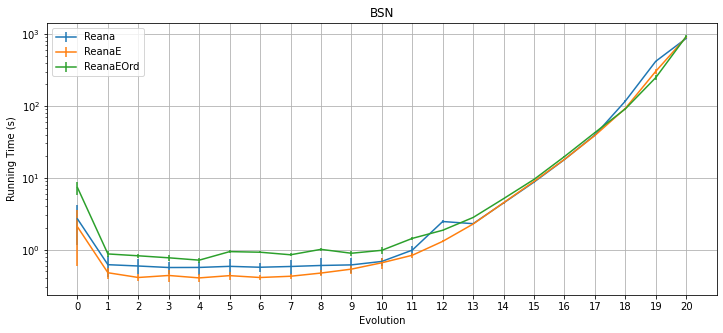

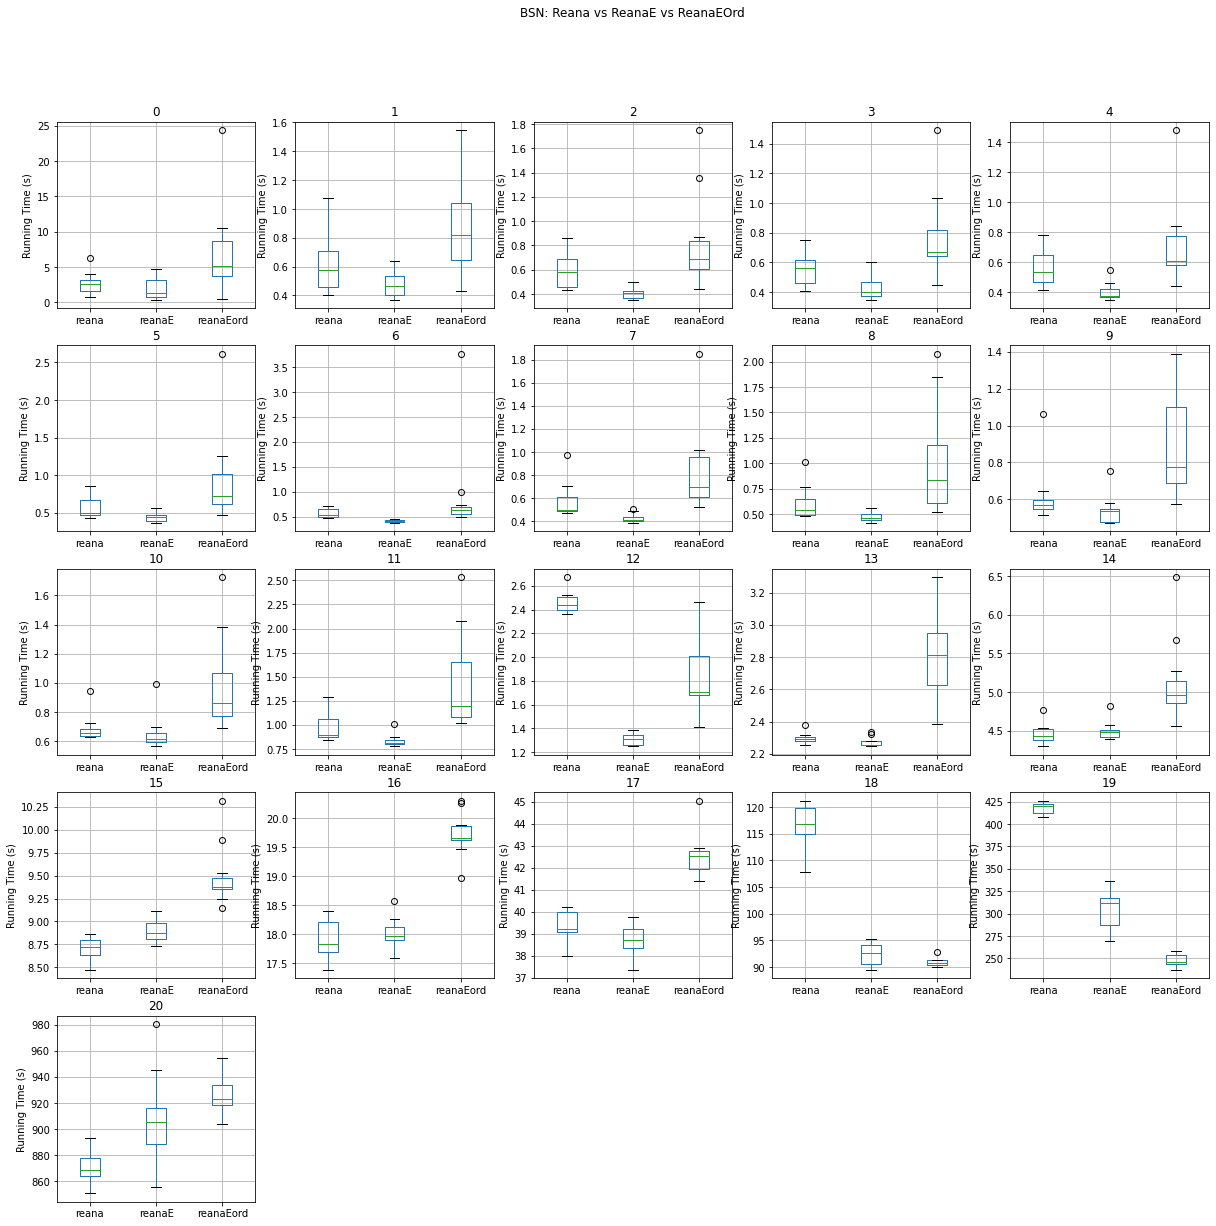

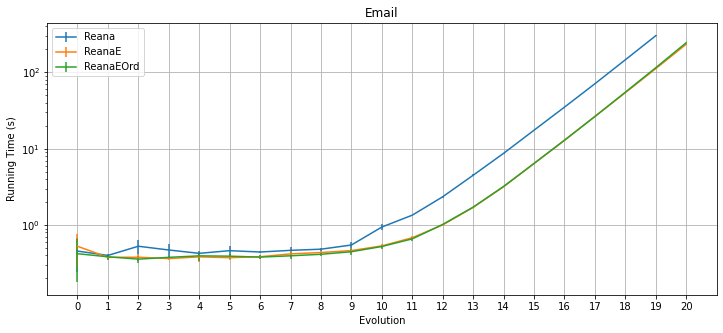

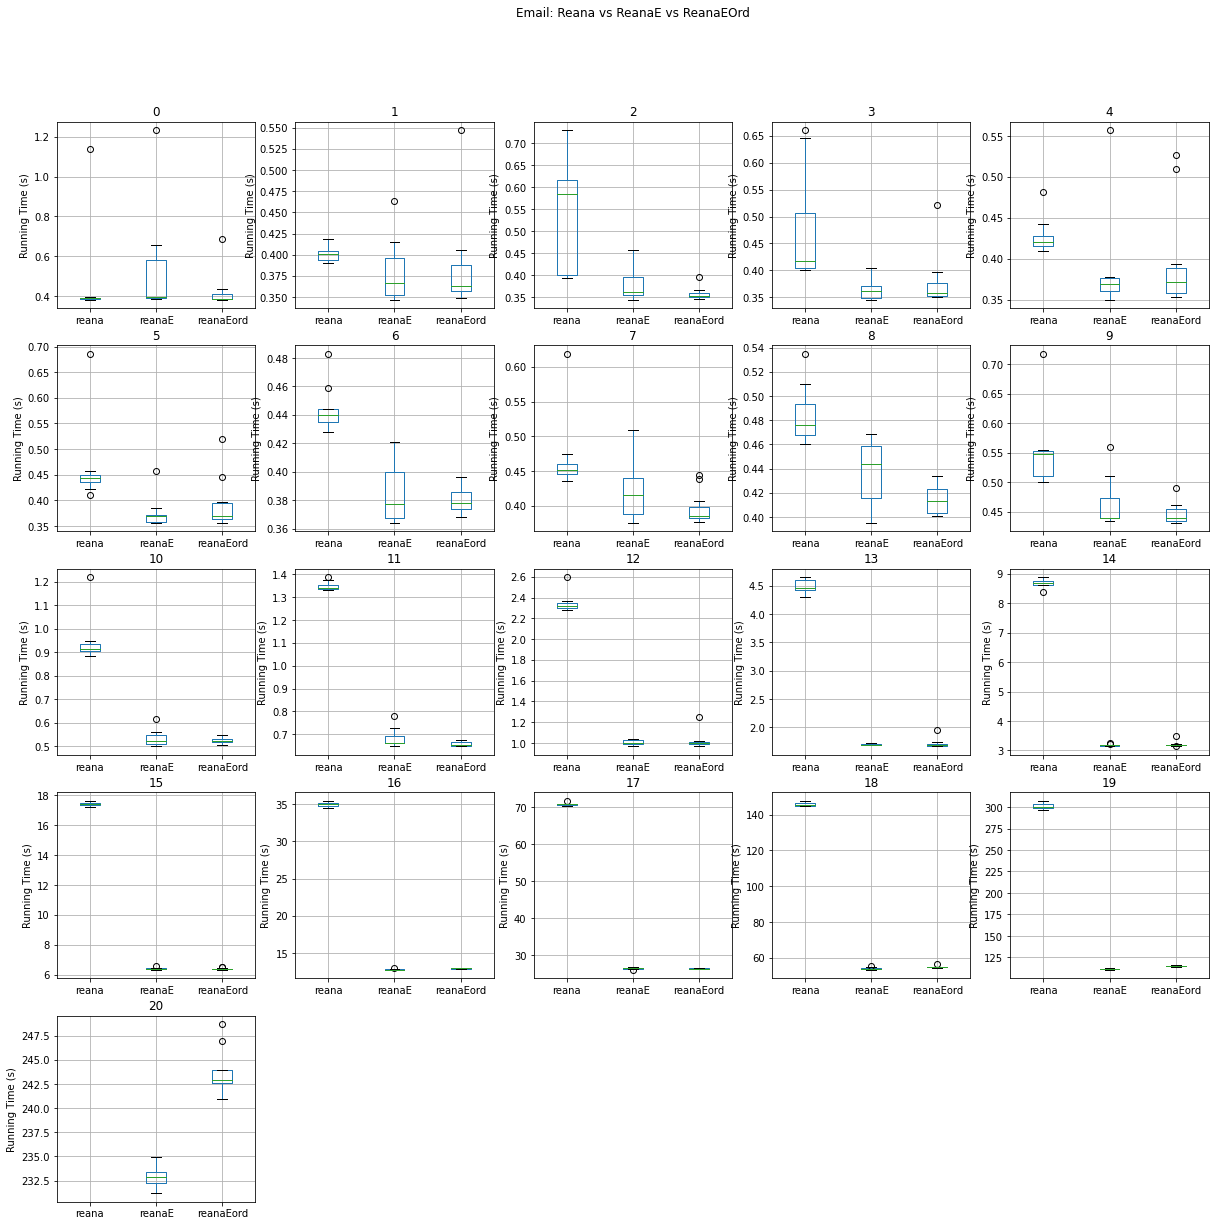

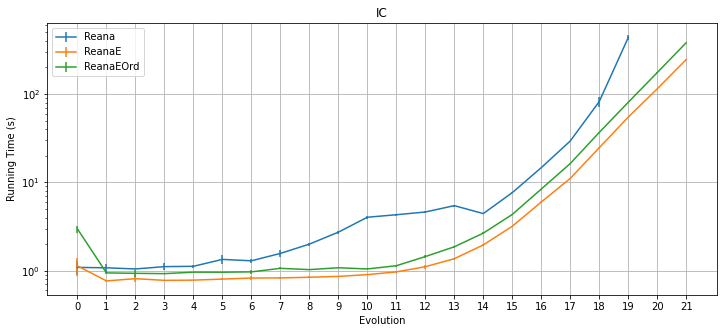

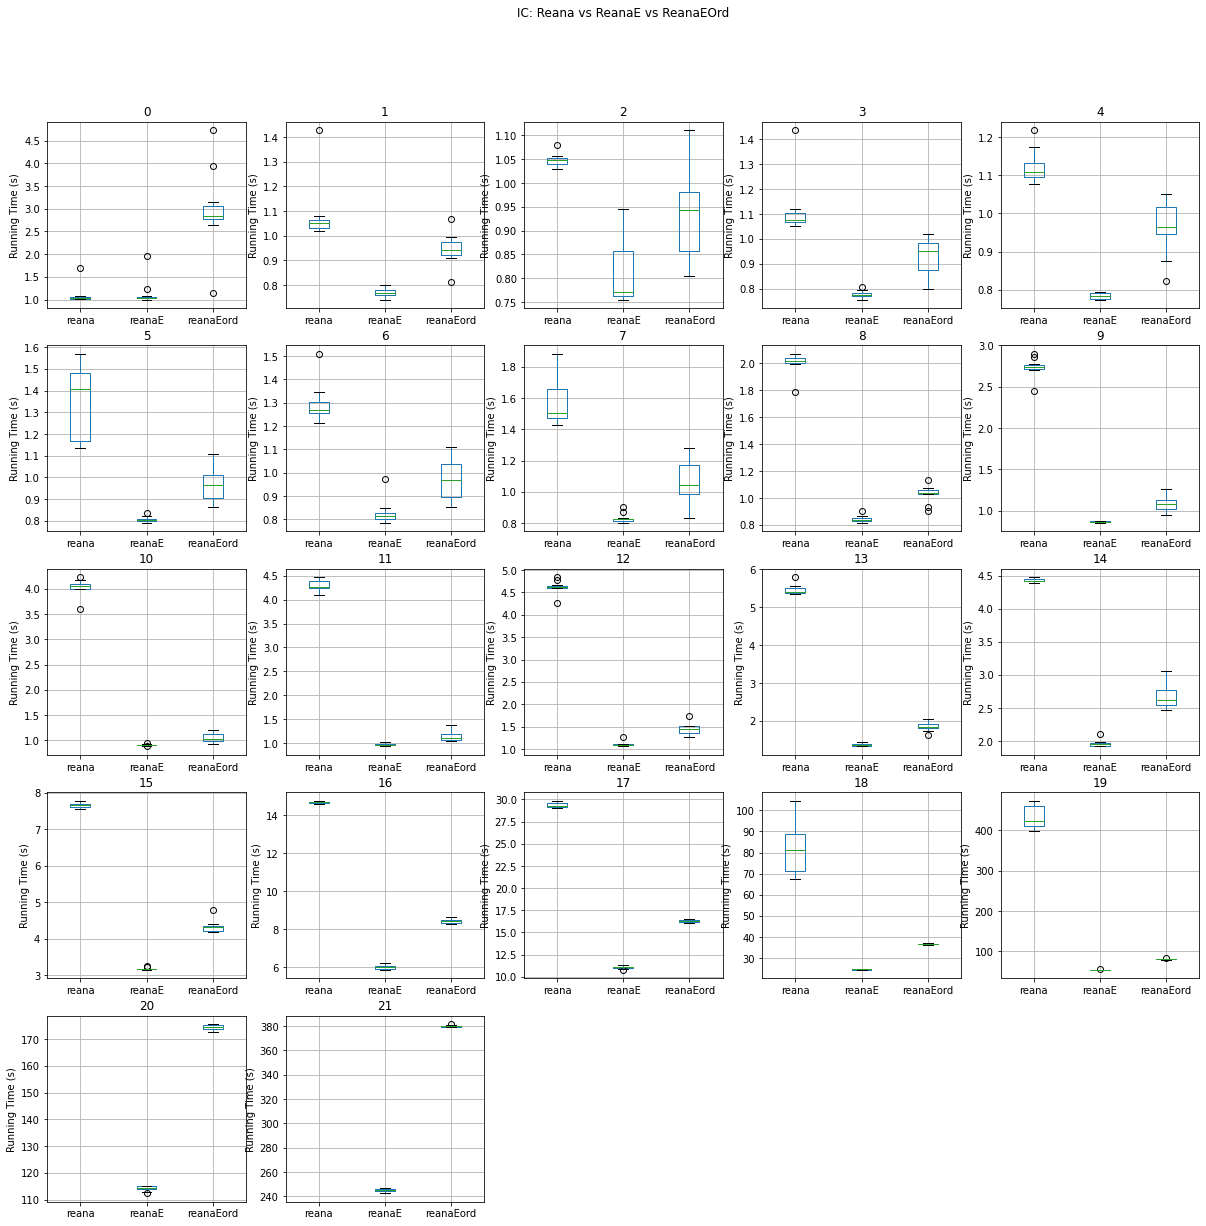

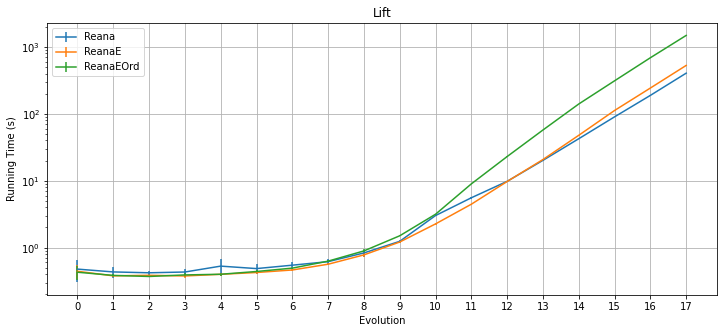

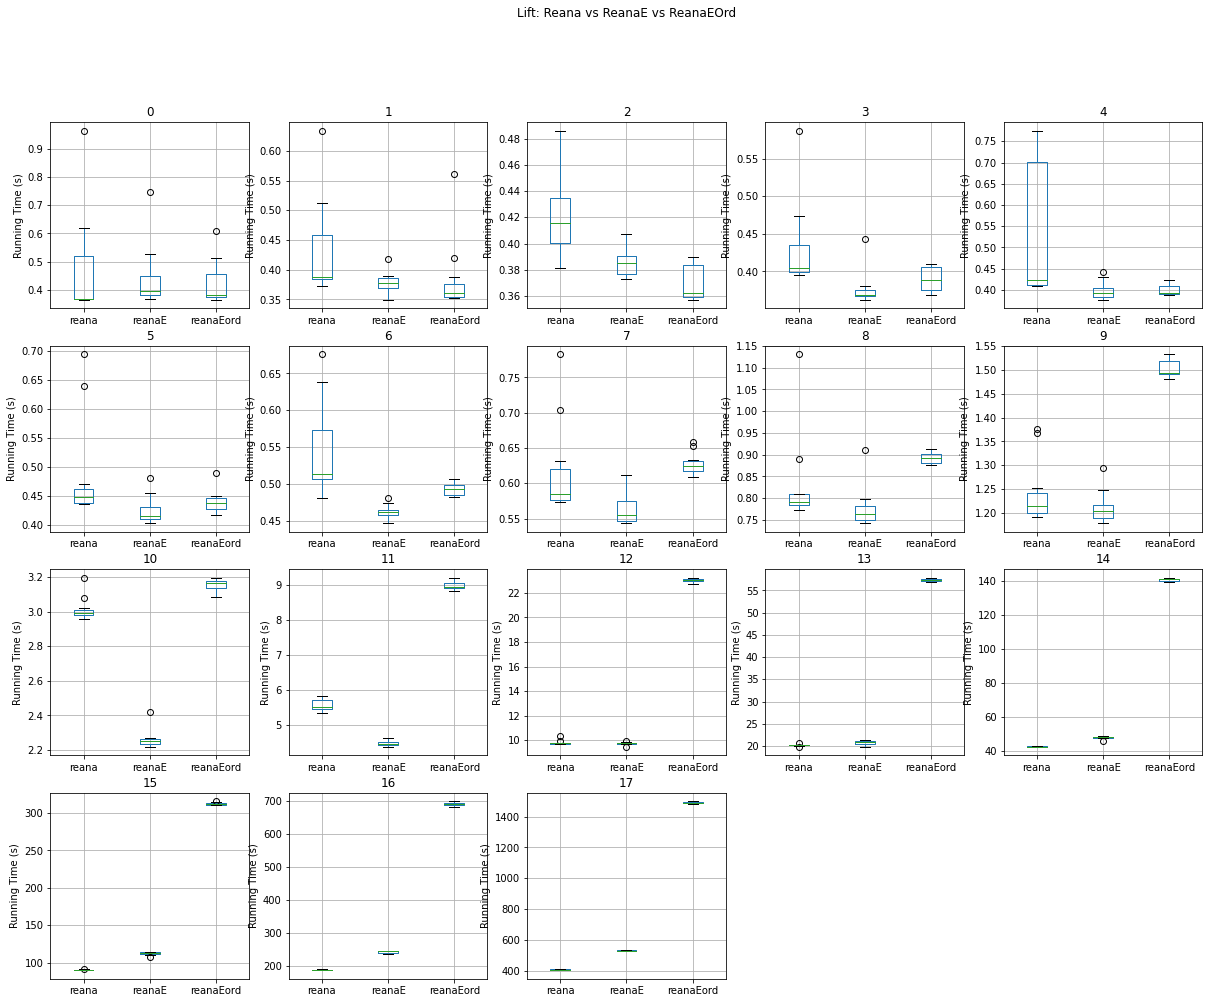

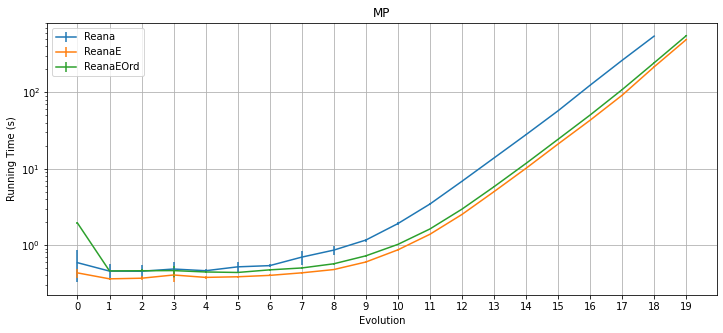

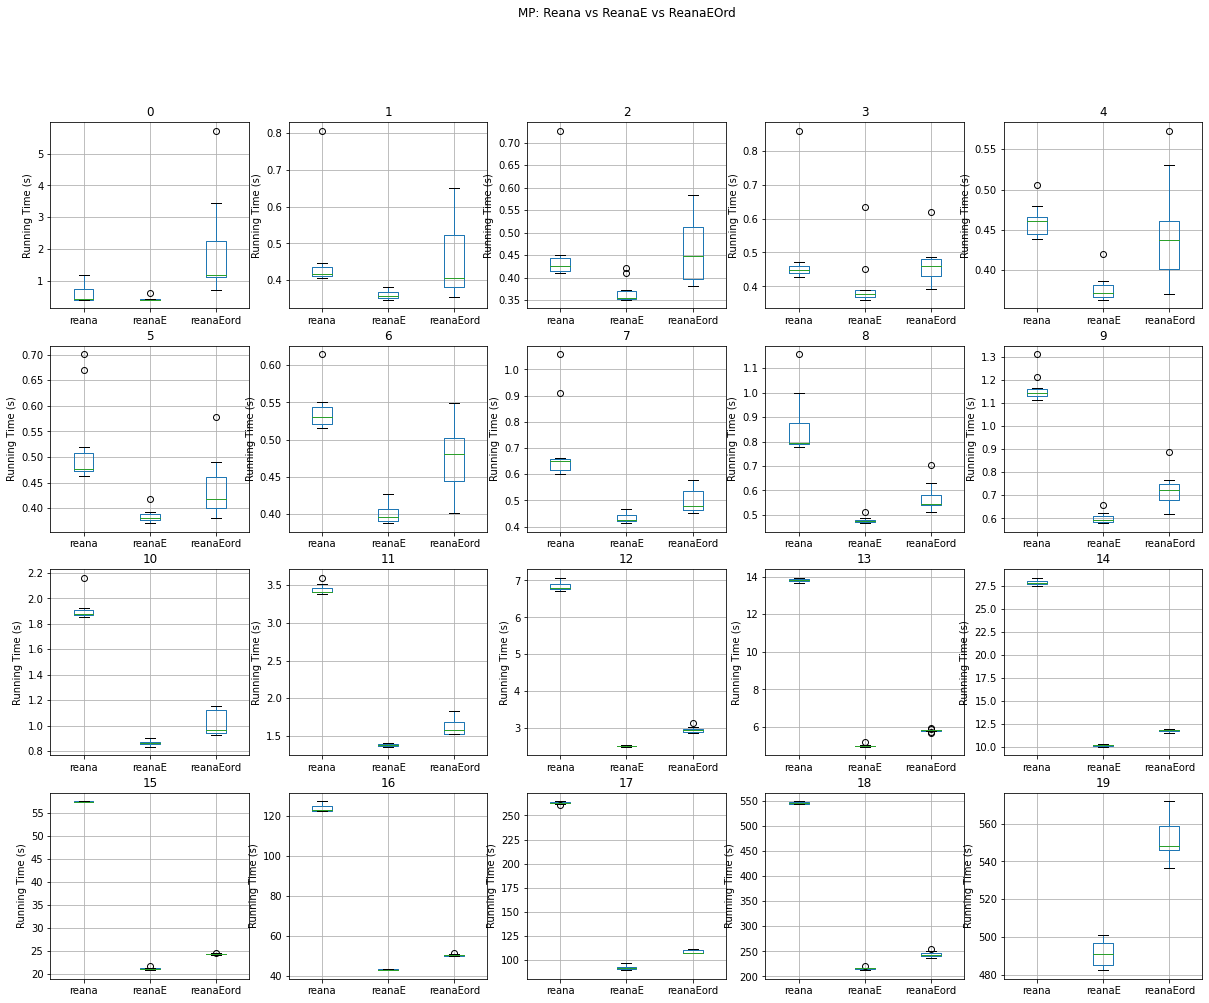

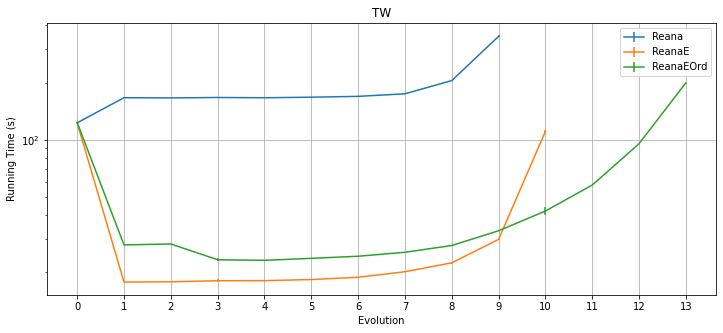

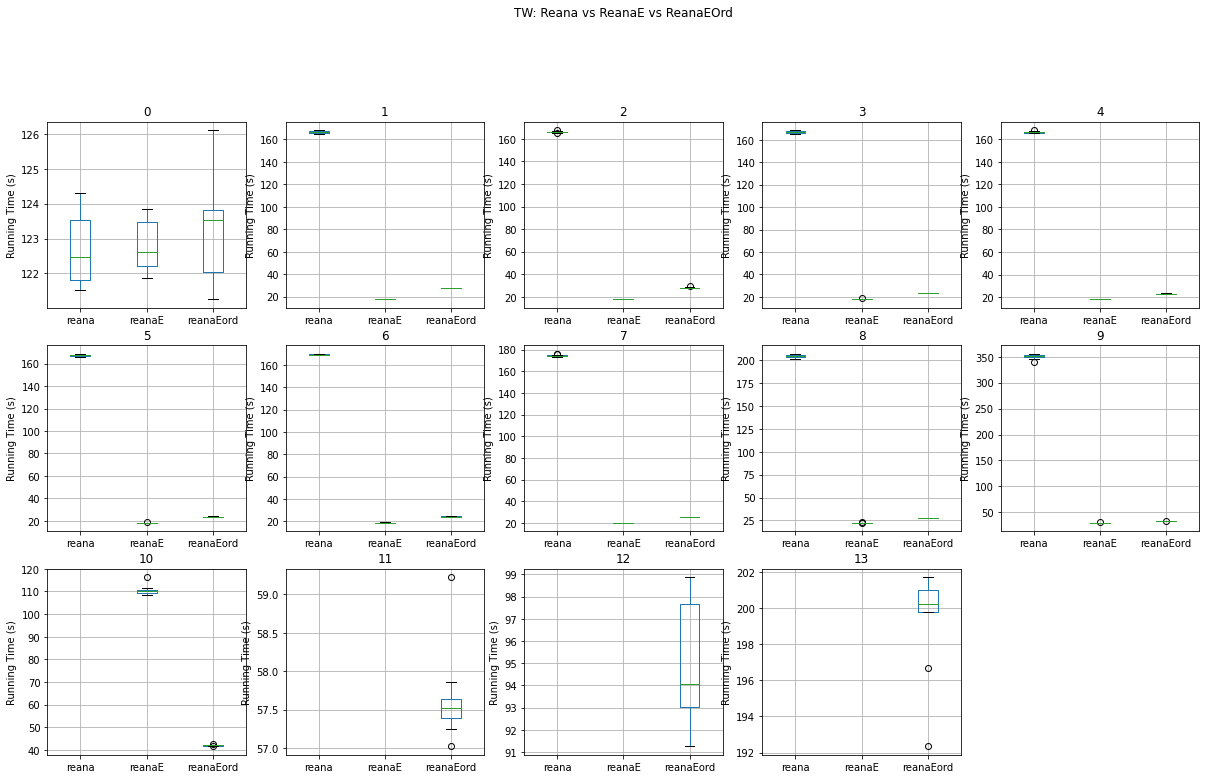

In [18]:
spls = ['BSN', 'Email', 'IC', 'Lift', 'MP', 'TW']
for spl in spls:
    plot_spl(spl)